In [3]:
# https://www.kaggle.com/competitions/contradictory-my-dear-watson
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow import keras
import keras_nlp
import seaborn as sns
import matplotlib.pyplot as plt
import os

print("TensorFlow version:", tf.__version__)
print("KerasNLP version:", keras_nlp.__version__)

c:\Users\nakamura\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Using TensorFlow backend
TensorFlow version: 2.10.1
KerasNLP version: 0.6.3


In [4]:
# ハードウェアを検出し、適切な配布戦略を返す
try:
    # TPUを検出して初期化する
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
    # 配布戦略を具体化する
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:
    print("TPU not activated")
    strategy = tf.distribute.MirroredStrategy() # 単一のVM内のCPU、単一GPU、および複数のGPUで動作します。
    
print("replicas:", strategy.num_replicas_in_sync)

TPU not activated
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
replicas: 1


In [5]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


In [6]:
df_train = pd.read_csv("./data/train.csv")
df_train.head()

,id,premise,hypothesis,lang_abv,language,label
0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,0
1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2
2,3931fbe82a,Des petites choses comme celles-là font une di...,J'essayais d'accomplir quelque chose.,fr,French,0
3,5622f0c60b,you know they can't really defend themselves l...,They can't defend themselves because of their ...,en,English,0
4,86aaa48b45,ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสด...,เด็กสามารถเห็นได้ว่าชาติพันธุ์แตกต่างกันอย่างไร,th,Thai,1


In [7]:
df_test = pd.read_csv("./data/test.csv")
df_test.head()

,id,premise,hypothesis,lang_abv,language
0,c6d58c3f69,بکس، کیسی، راہیل، یسعیاہ، کیلی، کیلی، اور کولم...,"کیسی کے لئے کوئی یادگار نہیں ہوگا, کولمین ہائی...",ur,Urdu
1,cefcc82292,هذا هو ما تم نصحنا به.,عندما يتم إخبارهم بما يجب عليهم فعله ، فشلت ال...,ar,Arabic
2,e98005252c,et cela est en grande partie dû au fait que le...,Les mères se droguent.,fr,French
3,58518c10ba,与城市及其他公民及社区组织代表就IMA的艺术发展进行对话&amp,IMA与其他组织合作，因为它们都依靠共享资金。,zh,Chinese
4,c32b0d16df,Она все еще была там.,"Мы думали, что она ушла, однако, она осталась.",ru,Russian


In [6]:
def display_pair_of_sentence(x):
    print( "Premise : " + x['premise'])
    print( "Hypothesis: " + x['hypothesis'])
    print( "Language: " + x['language'])
    print( "Label: " + str(x['label']))
    print()

df_train.head(10).apply(lambda x : display_pair_of_sentence(x), axis=1)

df_train.shape

Premise : and these comments were considered in formulating the interim rules.
Hypothesis: The rules developed in the interim were put together with these comments in mind.
Language: English
Label: 0

Premise : These are issues that we wrestle with in practice groups of law firms, she said. 
Hypothesis: Practice groups are not permitted to work on these issues.
Language: English
Label: 2

Premise : Des petites choses comme celles-là font une différence énorme dans ce que j'essaye de faire.
Hypothesis: J'essayais d'accomplir quelque chose.
Language: French
Label: 0

Premise : you know they can't really defend themselves like somebody grown uh say my age you know yeah
Hypothesis: They can't defend themselves because of their age.
Language: English
Label: 0

Premise : ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสดงออกและได้เล่นหลายบทบาทไปพร้อมกัน ๆ อาจช่วยให้เด็กจับความคล้ายคลึงและความแตกต่างระหว่างผู้คนในด้านความปรารถนา ความเชื่อ และความรู้สึกได้
Hypothesis: เด็กสามารถเห็นได้ว่าชาติพันธุ

(12120, 6)

Text(0.5, 1.0, 'Distribution of labels in the training set')

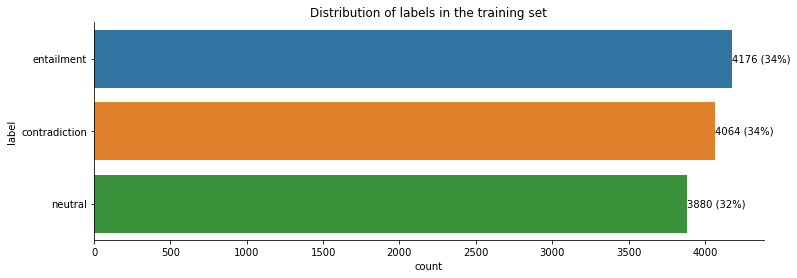

In [7]:
RESULT_DICT = {
    0 : "entailment",
    1 : "neutral",
    2 : "contradiction"
}
# matplotlib 図を初期化する
f, ax = plt.subplots(figsize=(12, 4))

# クラッシュの合計をプロットする
sns.set_color_codes("pastel")
sns.despine()
ax = sns.countplot(data=df_train, 
                   y="label",
                   order = df_train['label'].value_counts().index)

abs_values = df_train['label'].value_counts(ascending=False)
rel_values = df_train['label'].value_counts(ascending=False, normalize=True).values * 100
lbls = [f'{p[0]} ({p[1]:.0f}%)' for p in zip(abs_values, rel_values)]

ax.bar_label(container=ax.containers[0], labels=lbls)

ax.set_yticklabels([RESULT_DICT[index] for index in abs_values.index])

ax.set_title("Distribution of labels in the training set")

Text(0.5, 1.0, 'Distribution of languages in the training set')

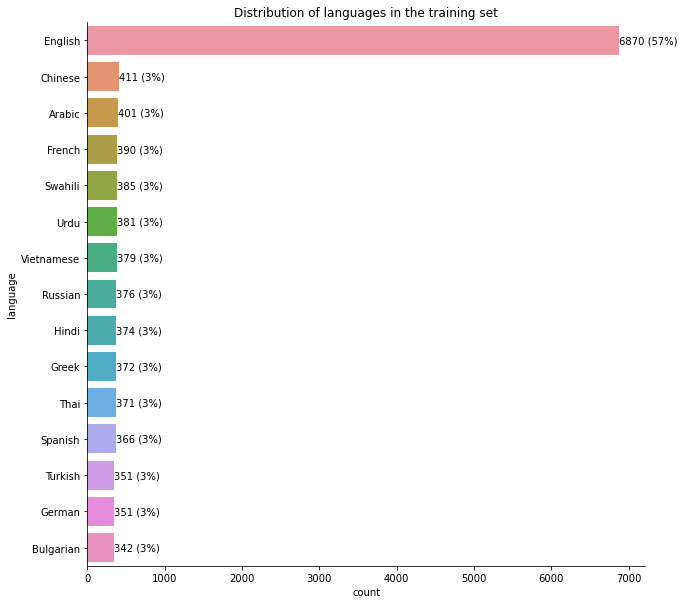

In [8]:
# matplotlib 図を初期化する
f, ax = plt.subplots(figsize=(10, 10))

# クラッシュの合計をプロットする
sns.set_color_codes("pastel")
sns.despine()
ax = sns.countplot(data=df_train, 
                   y="language",
                   order = df_train['language'].value_counts().index)

abs_values = df_train['language'].value_counts(ascending=False)
rel_values = df_train['language'].value_counts(ascending=False, normalize=True).values * 100
lbls = [f'{p[0]} ({p[1]:.0f}%)' for p in zip(abs_values, rel_values)]

ax.bar_label(container=ax.containers[0], labels=lbls)

ax.set_title("Distribution of languages in the training set")

In [9]:
df_train["premise_length"] = df_train["premise"].apply(lambda x : len(x))
df_train["hypothesis_length"] = df_train["hypothesis"].apply(lambda x : len(x))
df_train[["hypothesis_length", "premise_length"]].describe()

,hypothesis_length,premise_length
count,12120.000000,12120.000000
mean,53.892327,107.373185
std,25.302358,71.089954
min,4.000000,4.000000
25%,36.000000,55.000000
50%,51.000000,96.000000
75%,67.000000,146.000000
max,276.000000,967.000000


In [8]:
VALIDATION_SPLIT = 0.3
TRAIN_SIZE = int(df_train.shape[0]*(1-VALIDATION_SPLIT))
BATCH_SIZE = 16 * strategy.num_replicas_in_sync

def split_labels(x, y):
    return (x[0], x[1]), y

training_dataset = (
    tf.data.Dataset.from_tensor_slices(
        (
            df_train[['premise','hypothesis']].values,
            keras.utils.to_categorical(df_train['label'], num_classes=3)
        )
    )
)

train_dataset = training_dataset.take(TRAIN_SIZE)
val_dataset = training_dataset.skip(TRAIN_SIZE)

# 「map()」を使用して、train、val、test データのすべてのサンプルにプリプロセッサを適用します。
# [`tf.data.AUTOTUNE`](https://www.tensorflow.org/api_docs/python/tf/data/AUTOTUNE) と `prefetch()` はパフォーマンスを調整するためのオプションです。
# 詳細については、https://www.tensorflow.org/guide/data_performance 
train_preprocessed = train_dataset.map(split_labels, tf.data.AUTOTUNE).batch(BATCH_SIZE, drop_remainder=True).cache().prefetch(tf.data.AUTOTUNE)
val_preprocessed = val_dataset.map(split_labels, tf.data.AUTOTUNE).batch(BATCH_SIZE, drop_remainder=True).cache().prefetch(tf.data.AUTOTUNE)

In [9]:
# BERT モデルをロードします。
classifier = ''

with strategy.scope():
    classifier = keras_nlp.models.BertClassifier.from_preset("bert_base_multi", num_classes=3)

    # 分散トレーニングでは、ワーカーの数に応じてバッチサイズと学習率を調整することをお勧めします。
    classifier.compile(optimizer=keras.optimizers.Adam(1e-5*strategy.num_replicas_in_sync),
                       loss=keras.losses.CategoricalCrossentropy(from_logits=True),
                       metrics=['accuracy'])
    
    classifier.summary()



Preprocessor: "bert_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ bert_tokenizer (BertTokenizer)                     │                                             119,547 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "bert_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                  ┃ Output Shape                           ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)                     │ (None, None)                           │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ segment_ids (InputLayer)                      │ (None, None)                           │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ token_ids (InputLayer)                        │ (None, None)                           │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ bert_backbone (BertBackbone)                  │ {sequence_output: (None, None, 768),   │     177,853,440 │
│                                               │ pooled_output: (None, 768)}            │                 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ dropout (Dropout)                             │ (None, 768)                            │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ logits (Dense)                                │ (None, 3)                              │           2,307 │
└───────────────────────────────────────────────┴────────────────────────────────────────┴─────────────────┘

 Total params: 177,855,747 (678.47 MB)

 Trainable params: 177,855,747 (678.47 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# 独自のモデルをトレーニングする - BERT の微調整
EPOCHS=3
history = classifier.fit(train_preprocessed,
                         epochs=EPOCHS,
                         validation_data=val_preprocessed
                        )

Epoch 1/3


In [10]:
# 提出ファイルを生成する
predictions = classifier.predict((df_test['premise'],df_test['hypothesis']), batch_size=BATCH_SIZE)

submission = df_test.id.copy().to_frame()
submission["prediction"] = np.argmax(predictions, axis=1)

submission
submission.to_csv("submission.csv", index=False)

325/325 [==============================] - 6371s 20s/step
